In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.2 MB/s 
     |████████████████████████████████| 7.6 MB 38.6 MB/s 
     |████████████████████████████████| 182 kB 60.8 MB/s 


In [ ]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 4.2 MB/s 
     |████████████████████████████████| 212 kB 40.7 MB/s 
     |████████████████████████████████| 132 kB 70.8 MB/s 
     |████████████████████████████████| 127 kB 67.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import shutil
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import datasets
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from collections import defaultdict
from transformers import RobertaTokenizerFast, RobertaForQuestionAnswering
from datasets import load_dataset
from keras_preprocessing.sequence import pad_sequences

In [ ]:
#讀檔
squad_v2 = False
datasets = load_dataset( "squad_v2"  if squad_v2 else  "squad" )

#將資料格式調整為DataFrame
def convert_df(ori_data):
  data=[]
  for question_and_answers in ori_data:
    question=question_and_answers['question']
    context=question_and_answers['context']
    answr_text=question_and_answers['answers']['text'][0]
    answr_start=question_and_answers['answers']['answer_start'][0]
    answr_end=answr_start+len(answr_text)
    data.append({
        "question":question,
        "context":context,
        "answr_text":answr_text,
        "answr_start":answr_start,
        "answr_end":answr_end
    })
  return pd.DataFrame(data)

#將資料拆分成訓練、驗證、測試集
df_train=convert_df(datasets[ "train" ]).iloc[0:2000,:]
df_valid=convert_df(datasets[ "validation" ]).iloc[0:500,:]
df_valid,df_test=train_test_split(df_valid,test_size=0.5)
df_valid=df_valid.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
one=df_test.loc[20,:]
print('question:',one['question'])
print('context:',one['context'])
print('answer:',one['answr_text'])

question: In what year did the NFL switch to a 16-game regular season?
context: Despite waiving longtime running back DeAngelo Williams and losing top wide receiver Kelvin Benjamin to a torn ACL in the preseason, the Carolina Panthers had their best regular season in franchise history, becoming the seventh team to win at least 15 regular season games since the league expanded to a 16-game schedule in 1978. Carolina started the season 14–0, not only setting franchise records for the best start and the longest single-season winning streak, but also posting the best start to a season by an NFC team in NFL history, breaking the 13–0 record previously shared with the 2009 New Orleans Saints and the 2011 Green Bay Packers. With their NFC-best 15–1 regular season record, the Panthers clinched home-field advantage throughout the NFC playoffs for the first time in franchise history. Ten players were selected to the Pro Bowl (the most in franchise history) along with eight All-Pro selections.
an

In [ ]:
df_test.loc[2,:]['question']

'Who did the Broncos prevent from going to the Super Bowl?'

In [ ]:
df_test.loc[2,:]['context']

'The Panthers finished the regular season with a 15–1 record, and quarterback Cam Newton was named the NFL Most Valuable Player (MVP). They defeated the Arizona Cardinals 49–15 in the NFC Championship Game and advanced to their second Super Bowl appearance since the franchise was founded in 1995. The Broncos finished the regular season with a 12–4 record, and denied the New England Patriots a chance to defend their title from Super Bowl XLIX by defeating them 20–18 in the AFC Championship Game. They joined the Patriots, Dallas Cowboys, and Pittsburgh Steelers as one of four teams that have made eight appearances in the Super Bowl.'

In [ ]:
df_test.loc[2,:]['answr_text']

'New England Patriots'

In [ ]:
#資料預訓練模型
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
def Checklength(data):
  k=[]
  for i in range(len(data)):
    question=data.loc[i]['question']
    context	=data.loc[i]['context']
    k.append(len(tokenizer(question, context)["input_ids"]))
  return(max(k))

#檢查最長數據大小
print(Checklength(df_train),Checklength(df_valid),Checklength(df_test))

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

482 441 436


In [ ]:
EPOCHS=2
input_max_len=512
TRAIN_BATCH_SIZE=4
VALID_BATCH_SIZE=4
TEST_BATCH_SIZE=4

In [ ]:
# one=df_train.iloc[8,:]
# print("Question : {}".format(one['question']))
# print("Context : {}".format(one['context']))
# print("Answer : {}".format(one['answr_text']))
# print("Start : {}".format(one['answr_start']))
# print("End : {}".format(one['answr_end']))

Question : How many student news papers are found at Notre Dame?
Context : As at most other universities, Notre Dame's students run a number of news media outlets. The nine student-run outlets include three newspapers, both a radio and television station, and several magazines and journals. Begun as a one-page journal in September 1876, the Scholastic magazine is issued twice monthly and claims to be the oldest continuous collegiate publication in the United States. The other magazine, The Juggler, is released twice a year and focuses on student literature and artwork. The Dome yearbook is published annually. The newspapers have varying publication interests, with The Observer published daily and mainly reporting university and other news, and staffed by students from both Notre Dame and Saint Mary's College. Unlike Scholastic and The Dome, The Observer is an independent publication and does not have a faculty advisor or any editorial oversight from the University. In 1987, when some s

In [ ]:
# inputs = tokenizer(one.question, one.context,max_length= 512,padding='max_length',return_offsets_mapping=True,return_tensors="pt")

In [ ]:
# #原始答案起始與結束位置
# start=one['answr_start']
# end=one['answr_end']

# #修正答案位置
# sequence_ids=inputs['input_ids'].flatten()
# idx = 1
# while sequence_ids[idx].item() != 0 :
#   idx += 1
#   if sequence_ids[idx].item() ==2:
#     break
#   context_start = idx+3
# idx+=2
# try:
#   while sequence_ids[idx].item() !=2:
#         idx += 1
# except:
#   idx -= 1
# #context_end = idx - 1
# context_end = idx-1
# print(context_start,context_end)


# start_positions = []
# end_positions = []
# start_char=start
# end_char=end
# offset=inputs["offset_mapping"][0]
# if offset[context_start][0].item() > start_char or offset[context_end][1].item() < end_char:
#   start_positions.append(0)
#   end_positions.append(0)
# else:
#   # Otherwise it's the start and end token positions
#   idx = context_start
#   while idx <= context_end and offset[idx][0] <= start_char:
#     idx += 1
#   start_positions.append(idx - 1)

#   idx = context_end
#   while idx >= context_start and offset[idx][1] >= end_char:
#     idx -= 1
#   end_positions.append(idx+2)
# start_rel = start_positions[0]
# end_rel = end_positions[0]
# print(start_rel,end_rel)
# print(tokenizer.decode(inputs['input_ids'][0][start_rel:end_rel]))

14 274
39 40
 three


In [ ]:
#1004original
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, input_max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.input_max_len = input_max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data_row=self.df.iloc[index]

        inputs = self.tokenizer(
          data_row['question'],
          data_row['context'],
          max_length= self.input_max_len,
          padding='max_length',
          #回傳答案相對位置
          return_offsets_mapping=True,
          return_tensors="pt"
        )

        #原始答案起始與結束位置
        start=data_row['answr_start']
        end=data_row['answr_end']

        #修正答案位置
        sequence_ids=inputs['input_ids'].flatten()
        idx = 1
        while sequence_ids[idx].item() != 0 :
          idx += 1
          if sequence_ids[idx].item() ==2:
            break
          context_start = idx+3
        idx+=2
        try:
          while sequence_ids[idx].item() !=2:
                idx += 1
        except:
          idx -= 1
        #context_end = idx - 1
        context_end = idx-1

        start_positions = []
        end_positions = []
        start_char=start
        end_char=end
        offset=inputs["offset_mapping"][0]
        if offset[context_start][0].item() > start_char or offset[context_end][1].item() < end_char:
          start_positions.append(0)
          end_positions.append(0)
        else:
          # Otherwise it's the start and end token positions
          idx = context_start
          while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
          start_positions.append(idx - 1)

          idx = context_end
          while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
          end_positions.append(idx+2)
        start_rel = start_positions[0]
        end_rel = end_positions[0]

        return {
            'question':data_row['question'],
            'context':data_row['context'],
            'answer':data_row['answr_text'],
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            # 'token_type_ids': inputs["token_type_ids"].flatten(),
            'offsets_mapping':inputs["offset_mapping"],
            'start':start,
            'end':end,
            'start_rel':torch.tensor([start_rel],dtype=torch.long),
            'end_rel':torch.tensor([end_rel],dtype=torch.long)
        }

In [ ]:
# sample_train=CustomDataset(df_train, tokenizer,512)
# one=sample_train[15]
# #one=data[1]
# print(one['start_rel'])
# print(one['end_rel'])
# print(one['input_ids'])
# # print(one['token_type_ids'])
# # print(one['offsets_mapping'])
# start=one['start_rel']
# end=one['end_rel']
# labeled_answer = tokenizer.decode(one["input_ids"][start : end ])
# print(labeled_answer)
# print(one['answer'])

In [ ]:
#將資料轉換成特定格式
train_dataset = CustomDataset(df_train, tokenizer, input_max_len)
valid_dataset = CustomDataset(df_valid, tokenizer, input_max_len)
test_dataset = CustomDataset(df_test, tokenizer, input_max_len)

#批次數據集
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)
test_data_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

#使用GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
#加載模型參數
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into
    optimizer: optimizer we defined in previous training
    """
    # load check point
    # 如果使用cpu則後面需加上 map_location=torch.device('cpu')
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss
    return model, optimizer, checkpoint['epoch'], valid_loss_min

#儲存模型參數
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [ ]:
model = RobertaForQuestionAnswering.from_pretrained("roberta-base")
model.to(device)

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForQuestionAnswering: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use 

RobertaForQuestionAnswering(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:
#優化器
LEARNING_RATE=3e-5
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
#收集每次epoch訊息
history=defaultdict(list)

#訓練函數
def train(n_epochs, training_loader, validation_loader, model, optimizer, checkpoint_path, best_model_path):

  valid_loss_min = np.Inf

  for epoch in range(1,n_epochs+1):
    train_loss=0
    valid_loss=0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))

    for batch_idx, data in enumerate(training_loader):
      optimizer.zero_grad()

      input_ids=data['input_ids'].to(device)
      attention_mask =data['attention_mask'].to(device)
      start_positions=data['start_rel'].to(device)
      end_positions=data['end_rel'].to(device)
      outputs = model(input_ids,attention_mask,start_positions=start_positions,end_positions=end_positions)

      loss = outputs.loss

      #反向傳播
      loss.backward()

      #更新參數
      optimizer.step()

      #平均loss
      train_loss+=((1 / (batch_idx + 1)) * (loss.item() - train_loss))

    print('############# Epoch {}: Training End     #############'.format(epoch))

    print('############# Epoch {}: Validation Start   #############'.format(epoch))

    model.eval()

    #評估的時候不需要更新參數、計算梯度
    with torch.no_grad():

      #驗證集小批量迭代
      for batch_idx, data in enumerate(validation_loader, 0):

        #準備數據
        input_ids=data['input_ids'].to(device)
        attention_mask =data['attention_mask'].to(device)
        start_positions=data['start_rel'].to(device)
        end_positions=data['end_rel'].to(device)

        outputs = model(input_ids,attention_mask,start_positions=start_positions,end_positions=end_positions)

        loss = outputs.loss
        valid_loss+=((1 / (batch_idx + 1)) * (loss.item() - valid_loss))


      print('############# Epoch {}: Validation End     #############'.format(epoch))

      train_loss=train_loss
      valid_loss=valid_loss

      history['epoch'].append(epoch)
      history['train_loss'].append(train_loss)
      history['valid_loss'].append(valid_loss)

      #打印此epoch結果
      print('Epoch: {} \t Training Loss: {:.6f}  \tValidation Loss: {:.6f} '.format(
            epoch,
            train_loss,
            valid_loss
            ))

      #儲存重要資訊
      checkpoint = {
            'epoch': epoch,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }

      #儲存
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)

      ## 如果驗證loss降低，則儲存模型
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss


    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model

In [ ]:
#存放路徑
ckpt_path = "drive/MyDrive/roberta_qa_1114/curr_ckpt"
best_model_path = "drive/MyDrive/roberta_qa_1114/best_model.pt"
trained_model = train(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	 Training Loss: 2.139156  	Validation Loss: 1.312458 
Validation loss decreased (inf --> 1.312458).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	 Training Loss: 0.976089  	Validation Loss: 1.268644 
Validation loss decreased (1.312458 --> 1.268644).  Saving model ...
############# Epoch 2  Done   #############



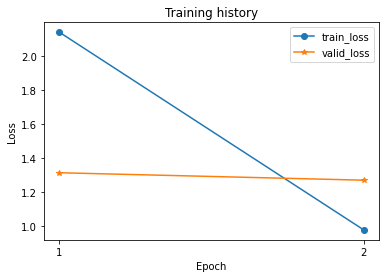

In [ ]:
#損失
plt.plot(history['epoch'],history['train_loss'], label='train_loss',marker="o")
plt.plot(history['epoch'],history['valid_loss'], label='valid_loss',marker="*")
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(history['epoch'])
plt.legend()

In [ ]:
#測試資料處理
import string, re

def normalize_text(s):
  """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
  def remove_articles(text):
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    return re.sub(regex, " ", text)
  def white_space_fix(text):
    return " ".join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return "".join(ch for ch in text if ch not in exclude)
  # 將字母統一以小寫形式表示
  def lower(text):
    return text.lower()

  return white_space_fix(remove_articles(remove_punc(s)))

#計算EM Score 函數
def exact_match(prediction, truth):
    return bool(normalize_text(prediction) == normalize_text(truth))

#計算F1 Score 函數
def compute_f1(prediction, truth):
  pred_tokens = normalize_text(prediction).split()
  truth_tokens = normalize_text(truth).split()

  # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
  if len(pred_tokens) == 0 or len(truth_tokens) == 0:
    return int(pred_tokens == truth_tokens)

  common_tokens = set(pred_tokens) & set(truth_tokens)

  # if there are no common tokens then f1 = 0
  if len(common_tokens) == 0:
    return 0

  prec = len(common_tokens) / len(pred_tokens)
  rec = len(common_tokens) / len(truth_tokens)

  return round(2 * (prec * rec) / (prec + rec), 2)

In [ ]:
#預測函數
def Test(model):
  F1_score=[]
  EM_score=[]
  model=model.eval()
  with torch.no_grad():
    for one in test_dataset:
      question=one['question']
      input_ids=one['input_ids'].to(device)
      attention_mask =one['attention_mask'].to(device)
      outputs = model(input_ids.reshape(1,512),attention_mask.reshape(1,512))
      answer_start_index = outputs.start_logits.argmax(dim=1)
      answer_end_index = outputs.end_logits.argmax(dim=1)

      #predict answer
      predict_answer = tokenizer.decode(one['input_ids'][answer_start_index.item() : answer_end_index.item()])

      #truth answer
      truth_answer = one['answer']

      F1_score.append(compute_f1(predict_answer,truth_answer))
      EM_score.append(exact_match(predict_answer,truth_answer))

  return sum(EM_score)/len(EM_score),np.mean(F1_score)

scores=Test(model)
EM,F1=scores
print("Exact match : {}".format(EM))
print("F1 score : {}".format(round(F1,2)))

Exact match : 0.656
F1 score : 0.73


In [ ]:
#開始預測
for one in test_dataset:
  question=one['question']
  input_ids=one['input_ids'].to(device)
  attention_mask =one['attention_mask'].to(device)
  outputs = model(input_ids.reshape(1,512),attention_mask.reshape(1,512))
  answer_start_index = outputs.start_logits.argmax(dim=1)
  answer_end_index = outputs.end_logits.argmax(dim=1)

  #predict answer
  predict_answer = tokenizer.decode(one['input_ids'][answer_start_index.item() : answer_end_index.item()])

  #truth answer
  truth_answer = one['answer']

  print("Question : {}".format(question))
  print("True Answer : {}".format(truth_answer))
  print("Pred Answer : {}".format(predict_answer))
  print("Exact match : {}".format(exact_match(predict_answer,truth_answer)))
  print("F1 score : {}\n".format(compute_f1(predict_answer,truth_answer)))

#predict

In [ ]:
import shutil
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import datasets
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from collections import defaultdict
from transformers import RobertaTokenizerFast, RobertaForQuestionAnswering
from datasets import load_dataset
from keras_preprocessing.sequence import pad_sequences

ModuleNotFoundError: ignored

In [ ]:
#加載模型參數
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into
    optimizer: optimizer we defined in previous training
    """
    # load check point
    # 如果使用cpu則後面需加上 map_location=torch.device('cpu')
    checkpoint = torch.load(checkpoint_fpath,map_location=torch.device('cpu'))
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss
    return model, optimizer, checkpoint['epoch'], valid_loss_min


In [ ]:
#使用GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
model = RobertaForQuestionAnswering.from_pretrained("roberta-base")

In [ ]:
LEARNING_RATE=3e-5
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
load_ckp('drive/MyDrive/roberta_qa_1114/best_model.pt', model, optimizer)

In [ ]:
def Predict(question,context):
  inputs = tokenizer(question,context,max_length= 512,padding='max_length',return_offsets_mapping=True,return_tensors="pt")
  input_ids=inputs['input_ids'].to(device)
  attention_mask =inputs['attention_mask'].to(device)
  outputs = model(input_ids.reshape(1,512),attention_mask.reshape(1,512))
  answer_start_index = outputs.start_logits.argmax(dim=1)
  answer_end_index = outputs.end_logits.argmax(dim=1)

  #predict answer
  predict_answer = tokenizer.decode(inputs['input_ids'].flatten()[answer_start_index.item() : answer_end_index.item()])
  return predict_answer

In [ ]:
one=df_train.iloc[25,:]

In [ ]:
Predict(one['question'],one['context'])